In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from scipy.stats import pearsonr
from adjustText import adjust_text
from statannot import add_stat_annotation
from scipy.stats import ttest_1samp
import sys
import os
sys.path.append(os.path.abspath('../'))
from DE_analysis_utils import get_DE_results_long
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'NimbusSanL'

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
datadir = '../../../../3_expts/processed_data'
de_by_guide = pd.read_csv('./results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('./results/DE_donor_robustness_correlation_summary.csv', index_col=0)
de_summary_stats = pd.read_csv(datadir + '/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
adata_de = ad.read_h5ad(datadir + '/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed=True)
de_donor_robustness = ad.read_h5ad(datadir + '/CD4i_final/CD4i_final.DE_donor_robustness.h5ad', backed=True)

In [3]:
adata_de

AnnData object with n_obs × n_vars = 33983 × 13959 backed at '../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad'
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [67]:
adata_stim = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].to_memory().copy()
masked_zscore = adata_stim.layers['masked_zscore'].copy()
#masked_zscore[adata_stim.layers['adj_p_value']>=0.05] = 0
adata_stim.layers['masked_zscore_filtered'] = masked_zscore.copy()

In [79]:
targets = ['IL10', 'IL21']
p_thresh = 0.1
robust_thres = 0.35 

In [85]:
name_to_id = dict(zip(adata_stim.var['gene_name'], adata_stim.var.index))

df_res = pd.DataFrame()

for t in targets:
    if t not in name_to_id:
        print(f"Warning: {t} not found in var['gene_name']")
        continue
        
    t_id = name_to_id[t] # Get Ensembl ID
    
    # Extract data using the ID
    pvals = adata_stim[:, t_id].layers['adj_p_value'].flatten()
    zscores = adata_stim[:, t_id].layers['masked_zscore'].flatten()
    
    temp_df = pd.DataFrame({
        'perturbation': adata_stim.obs['target_contrast_gene_name'],
        'target': t,
        'adj_p_value': pvals,
        'masked_zscore': zscores
    })
    df_res = pd.concat([df_res, temp_df])

# Filter for significance
sig_regulators = df_res[df_res['adj_p_value'] < p_thresh].copy()
sig_regulators['direction'] = sig_regulators['masked_zscore'].apply(
    lambda x: 'Positive' if x > 0 else 'Negative'
)

# Get unique list of regulator names
all_regulator_names = sig_regulators['perturbation'].unique()
print(f"Found {len(all_regulator_names)} unique regulators for {targets}")

Found 305 unique regulators for ['IL10', 'IL21']


In [86]:
valid_regulators = [g for g in all_regulator_names if g in name_to_id]

print(f"Analyzing hierarchy for {len(valid_regulators)} regulators...")

# Fetch by ID, Store by Name (Fixes mismatch & warning)
# We pull data using the Ensembl ID, but save it with the Gene Name key
reg_data_dict = {
    g_name: adata_stim[:, name_to_id[g_name]].layers['masked_zscore_filtered'].flatten()
    for g_name in valid_regulators
}

# Create DataFrame in one go
reg_df_full = pd.DataFrame(reg_data_dict, index=adata_stim.obs['target_contrast_gene_name'])

# Subset rows to only include the perturbations that are regulators
reg_matrix = reg_df_full.loc[valid_regulators].copy()

Analyzing hierarchy for 282 regulators...


In [87]:
IL10_pos = [g for g in valid_regulators if (adata_stim[adata_stim.obs.target_contrast_gene_name_corrected==g, adata_stim.var.gene_name=='IL10'].layers['masked_zscore']<0)&\
           (adata_stim[adata_stim.obs.target_contrast_gene_name_corrected==g, adata_stim.var.gene_name=='IL10'].layers['adj_p_value']<p_thresh)]
IL10_neg = [g for g in valid_regulators if (adata_stim[adata_stim.obs.target_contrast_gene_name_corrected==g, adata_stim.var.gene_name=='IL10'].layers['masked_zscore']>0)&\
           (adata_stim[adata_stim.obs.target_contrast_gene_name_corrected==g, adata_stim.var.gene_name=='IL10'].layers['adj_p_value']<p_thresh)]
IL21_pos = [g for g in valid_regulators if (adata_stim[adata_stim.obs.target_contrast_gene_name_corrected==g, adata_stim.var.gene_name=='IL21'].layers['masked_zscore']<0)&\
           (adata_stim[adata_stim.obs.target_contrast_gene_name_corrected==g, adata_stim.var.gene_name=='IL21'].layers['adj_p_value']<p_thresh)]
IL21_neg = [g for g in valid_regulators if (adata_stim[adata_stim.obs.target_contrast_gene_name_corrected==g, adata_stim.var.gene_name=='IL21'].layers['masked_zscore']>0)&\
           (adata_stim[adata_stim.obs.target_contrast_gene_name_corrected==g, adata_stim.var.gene_name=='IL21'].layers['adj_p_value']<p_thresh)]

In [88]:
len(IL10_pos), len(IL10_neg), len(IL21_pos), len(IL21_neg)

(181, 25, 29, 60)

In [84]:
all_regulator_names = list(set(all_regulator_names) & set(donor_robustness_summary[donor_robustness_summary['donor_correlation_min']>robust_thres].target_name))
all_regulator_names = all_regulator_names + ['IL10']
len(all_regulator_names)

176

In [140]:
reg_matrix

,SLC35B1,GTF3C5,STXBP4,COX6B1,XPR1,PRKAR1A,UVRAG,DDX6,CROT,ARNT,...,NSD1,EIF4G2,ACTR8,GDAP2,PPCS,DZIP1,ARHGAP45,PGK1,BRD9,IL10
target_contrast_gene_name,,,,,,,,,,,,,,,,,,,,,
SLC35B1,0.000000,-0.067469,0.077421,-0.265843,0.287734,1.107684,-0.942617,-0.398847,-0.472522,0.610790,...,-0.822507,1.668630,-0.000428,-0.227160,2.294484,0.262806,0.990862,-1.482412,0.543847,-3.434097
GTF3C5,-0.871970,0.000000,-0.364814,-0.718030,0.386122,-0.332224,0.936028,3.518279,0.216119,0.085593,...,-0.782986,-2.040409,-1.062845,1.587139,3.986083,0.351551,-1.362202,-1.545991,-0.444640,-3.586386
STXBP4,-2.678856,-1.364259,0.000000,-2.483813,0.517960,-0.359430,-1.544476,1.757546,-0.634050,-0.163167,...,2.432987,-0.561083,2.666031,2.766715,1.560485,0.969186,-1.790026,-1.620058,-1.336955,-3.076530
COX6B1,0.047339,-1.513078,-0.144585,0.000000,-0.548540,0.500291,-0.842566,1.177899,-1.606155,0.870340,...,3.039528,0.859220,0.972415,0.174826,0.725612,-0.301755,-1.797402,-1.532861,0.360788,-4.706064
XPR1,-2.094522,-0.086338,0.243558,-0.097157,0.000000,1.756291,-0.410281,-1.101293,1.458500,-0.699906,...,2.438791,1.551628,1.392075,1.751929,-0.148751,0.161245,1.367637,0.914782,0.582937,-2.784187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DZIP1,0.663964,0.225281,-1.549745,1.427675,-1.939615,1.809176,1.365839,1.041273,1.748824,-0.263736,...,-0.258054,-0.846395,-0.361109,-0.489169,-0.411592,0.000000,0.692414,1.423760,-1.339069,1.340803
ARHGAP45,0.902880,0.013773,-0.387184,1.884119,-0.552233,0.692087,-1.294082,-1.108321,2.187858,0.530069,...,0.614254,0.428916,-0.833606,0.384060,-1.099892,-0.246163,0.000000,1.069300,-1.422303,-4.727202
PGK1,-0.996073,-0.425172,-0.539781,0.659247,0.893523,0.527284,-0.350318,1.045841,1.281837,0.221871,...,0.055894,-0.699317,0.017981,2.383767,0.820644,0.661298,-1.128927,0.000000,-1.850028,-2.867200


In [143]:
row_order

array([163, 129, 130, 162,  79, 131,  77, 135, 136, 137, 138, 139,  69,
        68,  67,  66,  62, 144,  57,  56, 145,  53,  85,  52,  86, 128,
       117, 120, 114, 112, 121, 110, 109, 108, 123, 104, 103, 102, 124,
       125,  98, 126,  95,  94,  93,  92,  91,  88,  50, 143,  48,  29,
        27,  49,  25,  23,  22, 154, 155,  18,  17,  14,  13,  12, 157,
        10, 158, 159,   7,   6, 160,   3,   2, 161,  30,  31, 152,  37,
        43,  44, 150,  39,  45,  38,  36,  41,  46,  34,  47,  33,  35,
       113,   4,  61, 146, 115,  51, 105, 118,  75, 156,  99,  32,  80,
       151,  83,  24,  87,  89,  63, 119, 140, 127,  16,  65, 122, 148,
       142, 134, 153,  81,  60,  54,  64,  71,  42,  40,  59,  82,  58,
       101,  15,  20,  11,  26,  28,   9, 149,   8, 147,   5,   1,  55,
        19,  21, 111, 141, 107, 106, 100,  97,  96,  90,  84,  78, 132,
       133,  76,  74,  73,  72,  70, 116,   0])

In [95]:
TCR_gene = ['CD3D', 'CD3E', 'CD3G', 'LAT', 'VAV1', 'PLCG1', 'LCP2', 'ZAP70', 'LRBA', 'ZBED3', 'BCAT2', 'LCK']
#reg_matrix.loc[TCR_gene, :] = 0
reg_matrix.drop(labels=TCR_gene, axis=1, inplace=True)
reg_matrix.drop(labels=TCR_gene, axis=0, inplace=True)

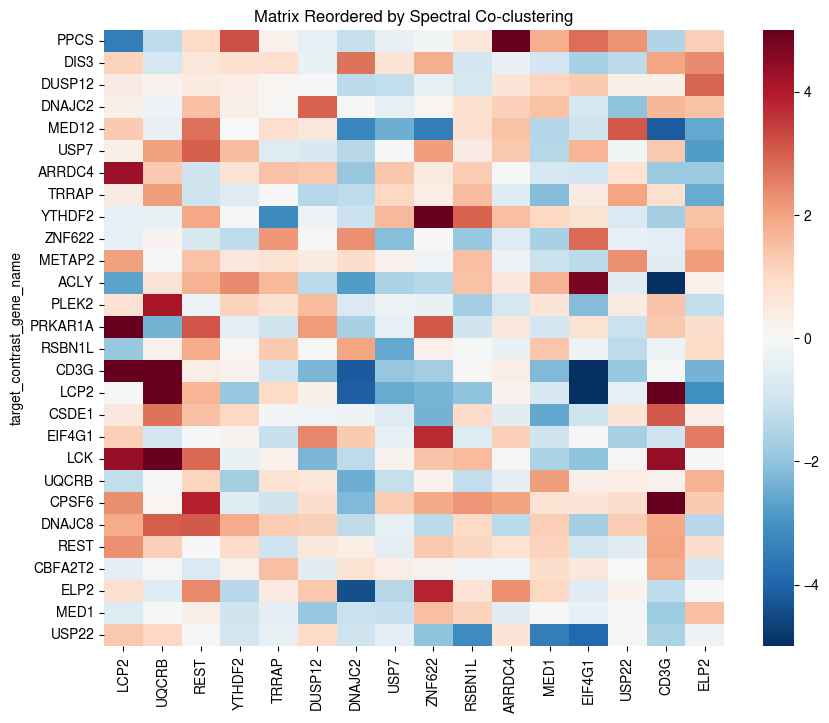

In [74]:
from sklearn.cluster import SpectralCoclustering
model = SpectralCoclustering(n_clusters=5, random_state=0)
model.fit(reg_matrix.loc[IL21_pos,IL10_neg].values)
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)
sorted_row_genes = reg_matrix.index[row_order]
sorted_col_genes = reg_matrix.columns[col_order]
plt.figure(figsize=(10, 8))
sns.heatmap(reg_matrix.loc[sorted_row_genes, sorted_col_genes], cmap='RdBu_r', vmin=-5, vmax=5)
plt.title("Matrix Reordered by Spectral Co-clustering")
plt.show()

In [97]:
reg_dict = {'IL10_pos': IL10_pos,
            'IL10_neg': IL10_neg,
            'IL21_pos': IL21_pos,
            'IL21_neg': IL21_neg}

In [ ]:
x_all = ['IL10_pos', 'IL10_neg', 'IL21_pos', 'IL21_neg']
y_all = ['IL10_pos', 'IL10_neg', 'IL21_pos', 'IL21_neg']
for x in x_all:
    for y in y_all:
        # Visualization 1: Clustermap
        g = sns.clustermap(
            reg_matrix.loc[reg_dict[x],reg_dict[y]],
            method='ward',
            cmap='RdBu_r',
            center=0,
            figsize=(len(reg_dict[y])/5,len(reg_dict[x])/5),
            vmin=-5,
            vmax=5,
            xticklabels=True, 
            yticklabels=True,
            
        )
        
        # Hide the row and column dendrograms
        g.ax_row_dendrogram.set_visible(False)
        g.ax_col_dendrogram.set_visible(False)
        g.cax.set_visible(False)
        plt.tight_layout()
        plt.savefig('results/IL10_IL21_mininetwork'+'_'+x+'_'+y+'_TCR_filtered.png', dpi=600, bbox_inches='tight', pad_inches=0)
        plt.close()

In [101]:
reg_dict = {'IL10_pos': list(set(IL10_pos)-set(TCR_gene)),
            'IL10_neg': list(set(IL10_neg)-set(TCR_gene)),
            'IL21_pos': list(set(IL21_pos)-set(TCR_gene)),
            'IL21_neg': list(set(IL21_pos)-set(TCR_gene))}
x_all = ['IL10_pos', 'IL10_neg', 'IL21_pos', 'IL21_neg']
y_all = ['IL10_pos', 'IL10_neg', 'IL21_pos', 'IL21_neg']
for x in x_all:
    for y in y_all:
        # Visualization 1: Clustermap
        g = sns.clustermap(
            reg_matrix.loc[reg_dict[x],reg_dict[y]],
            method='ward',
            cmap='RdBu_r',
            center=0,
            figsize=(len(reg_dict[y])/5,len(reg_dict[x])/5),
            vmin=-5,
            vmax=5,
            xticklabels=True, 
            yticklabels=True,
            
        )
        
        # Hide the row and column dendrograms
        g.ax_row_dendrogram.set_visible(False)
        g.ax_col_dendrogram.set_visible(False)
        g.cax.set_visible(False)
        plt.tight_layout()
        plt.savefig('results/IL10_IL21_mininetwork'+'_'+x+'_'+y+'_TCR_filtered.png', dpi=600, bbox_inches='tight', pad_inches=0)
        plt.close()

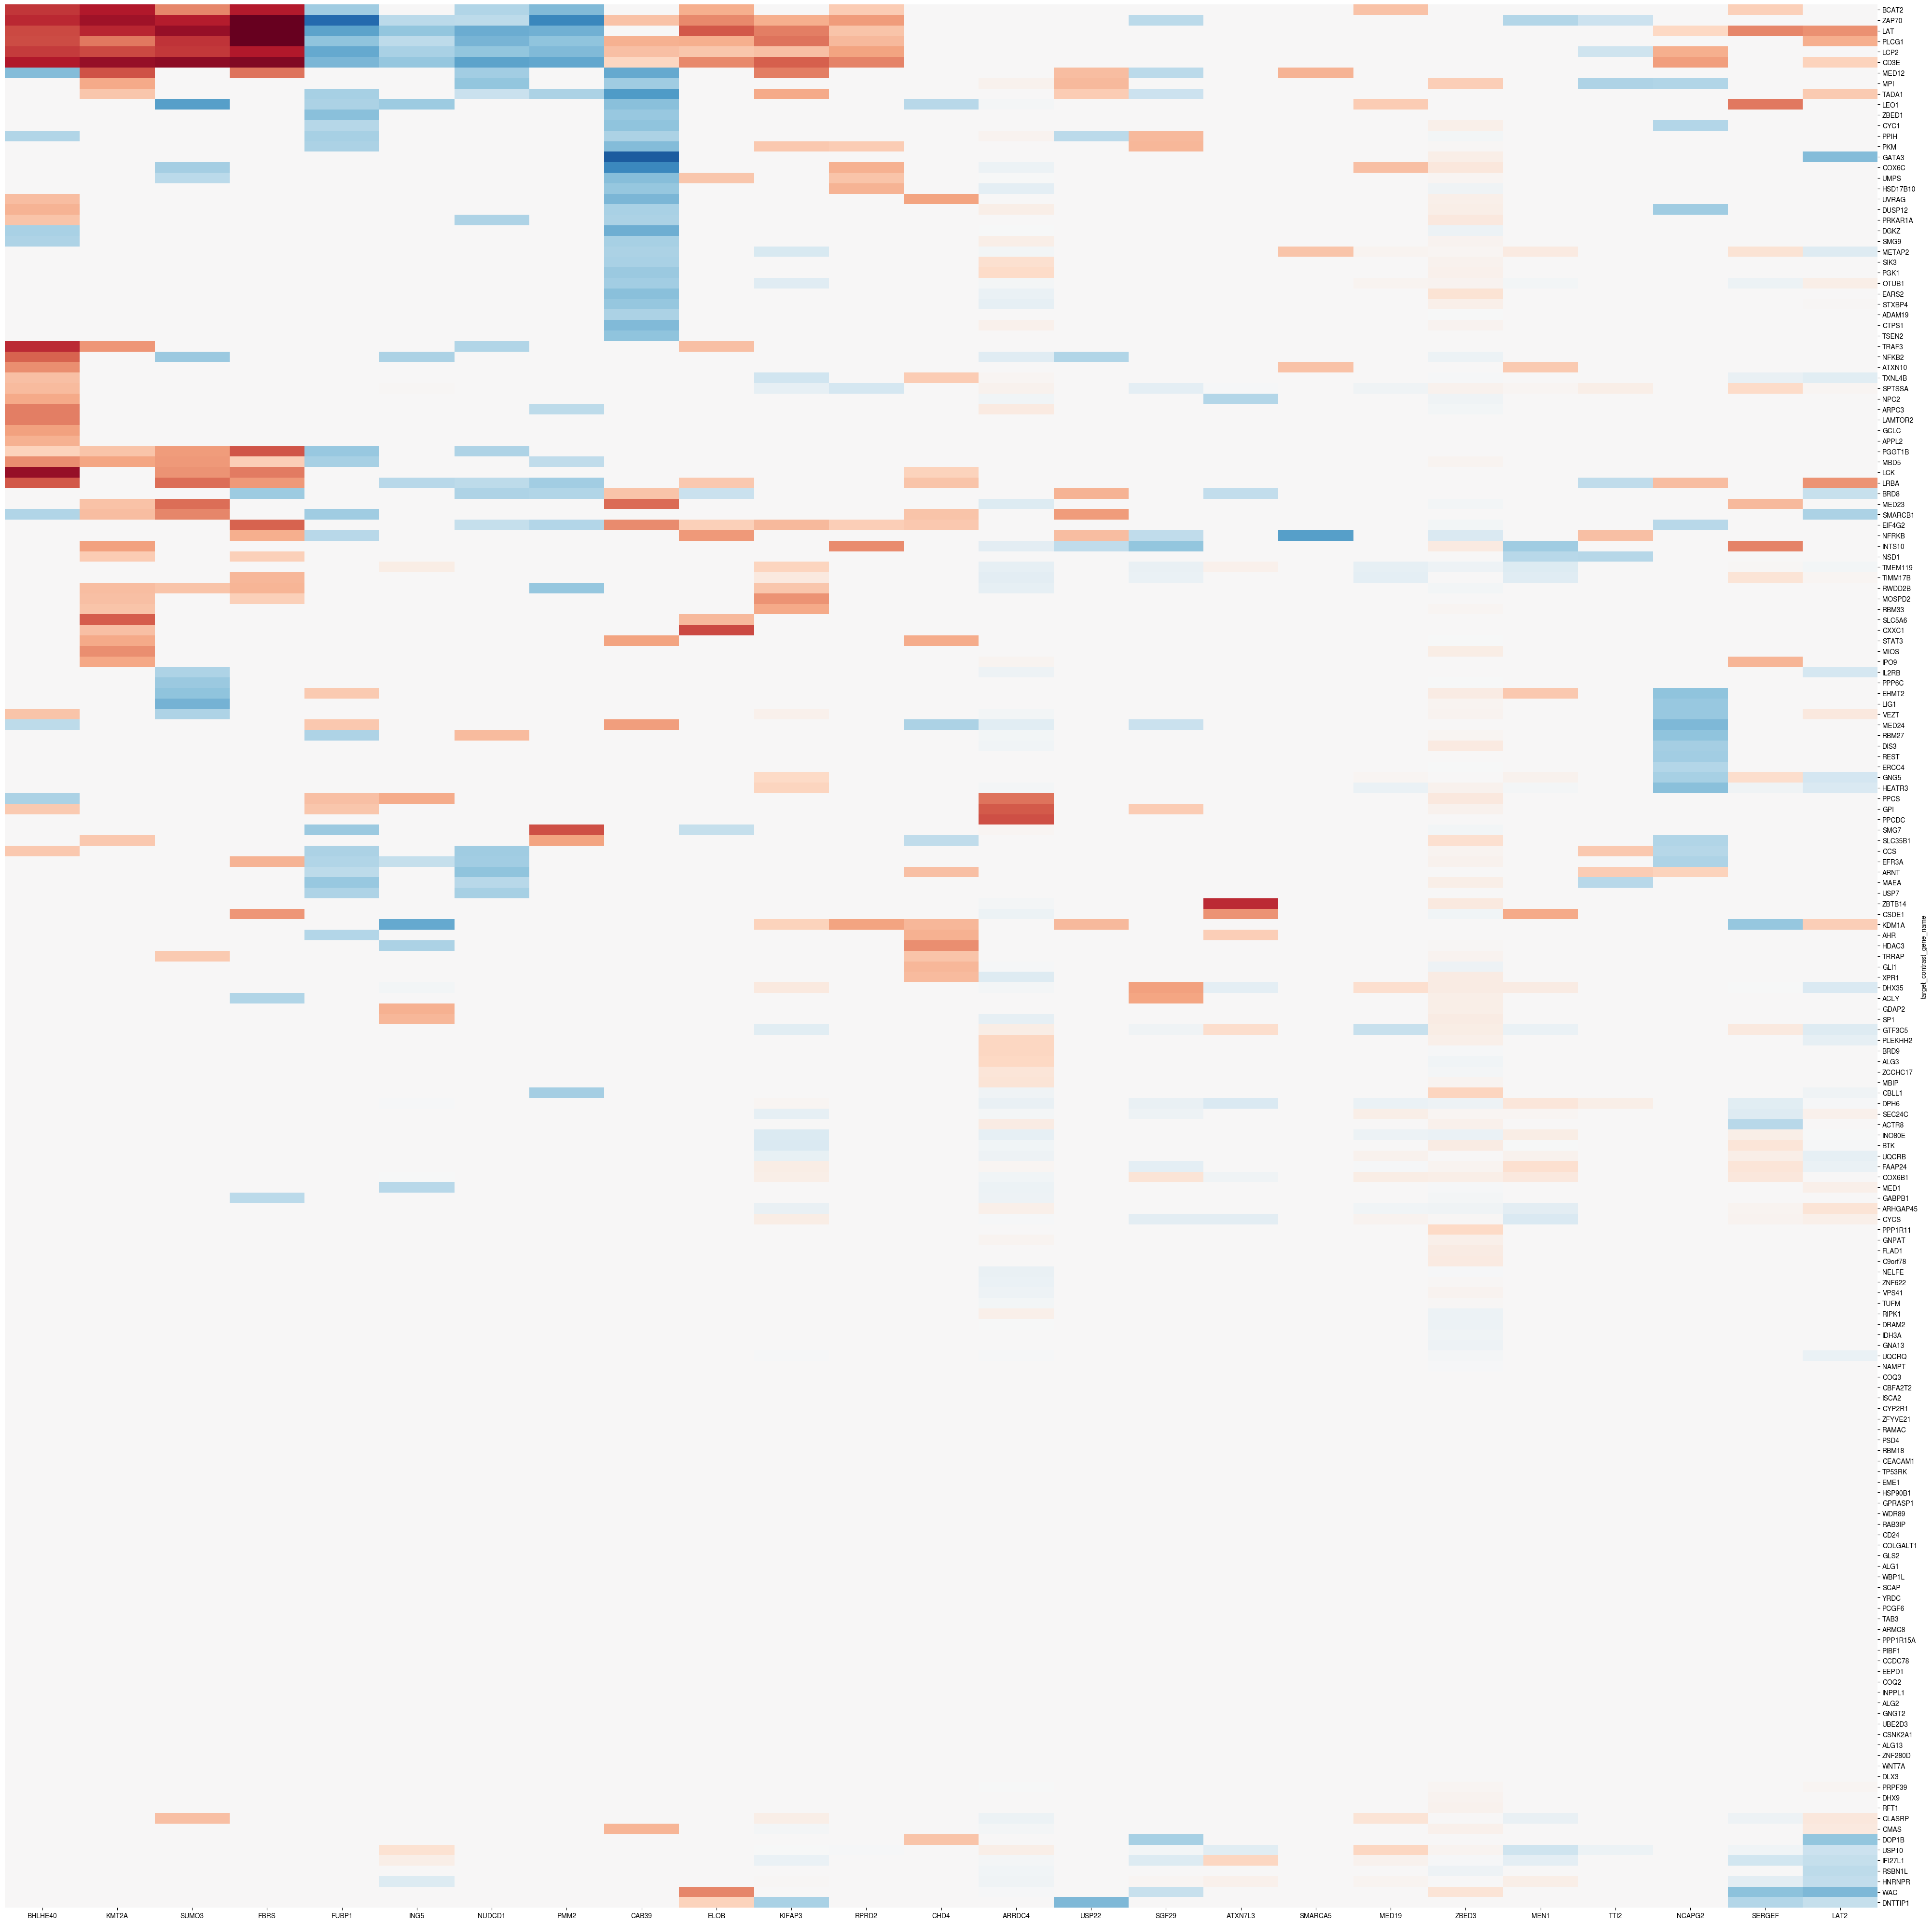

In [173]:
# Visualization 1: Clustermap
g = sns.clustermap(
    reg_matrix.loc[IL10_pos,IL10_neg],
    method='ward',
    cmap='RdBu_r',
    center=0,
    figsize=(50, 50),
    vmin=-10,
    vmax=10,
    xticklabels=True, 
    yticklabels=True,
    
)

# Hide the row and column dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
plt.tight_layout()
#plt.savefig('results/IL10_IL21_mininetwork.pdf', bbox_inches='tight', pad_inches=0)
#plt.show()

In [ ]:
# Visualization 1: Clustermap
g = sns.clustermap(
    reg_matrix.loc[IL21_pos,IL21_pos],
    method='ward',
    cmap='RdBu_r',
    center=0,
    figsize=(50, 50),
    vmin=-10,
    vmax=10,
    xticklabels=True, 
    yticklabels=True,
    
)

# Hide the row and column dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
plt.tight_layout()
#plt.savefig('results/IL10_IL21_mininetwork.pdf', bbox_inches='tight', pad_inches=0)
#plt.show()

Analyzing hierarchy for 164 regulators...


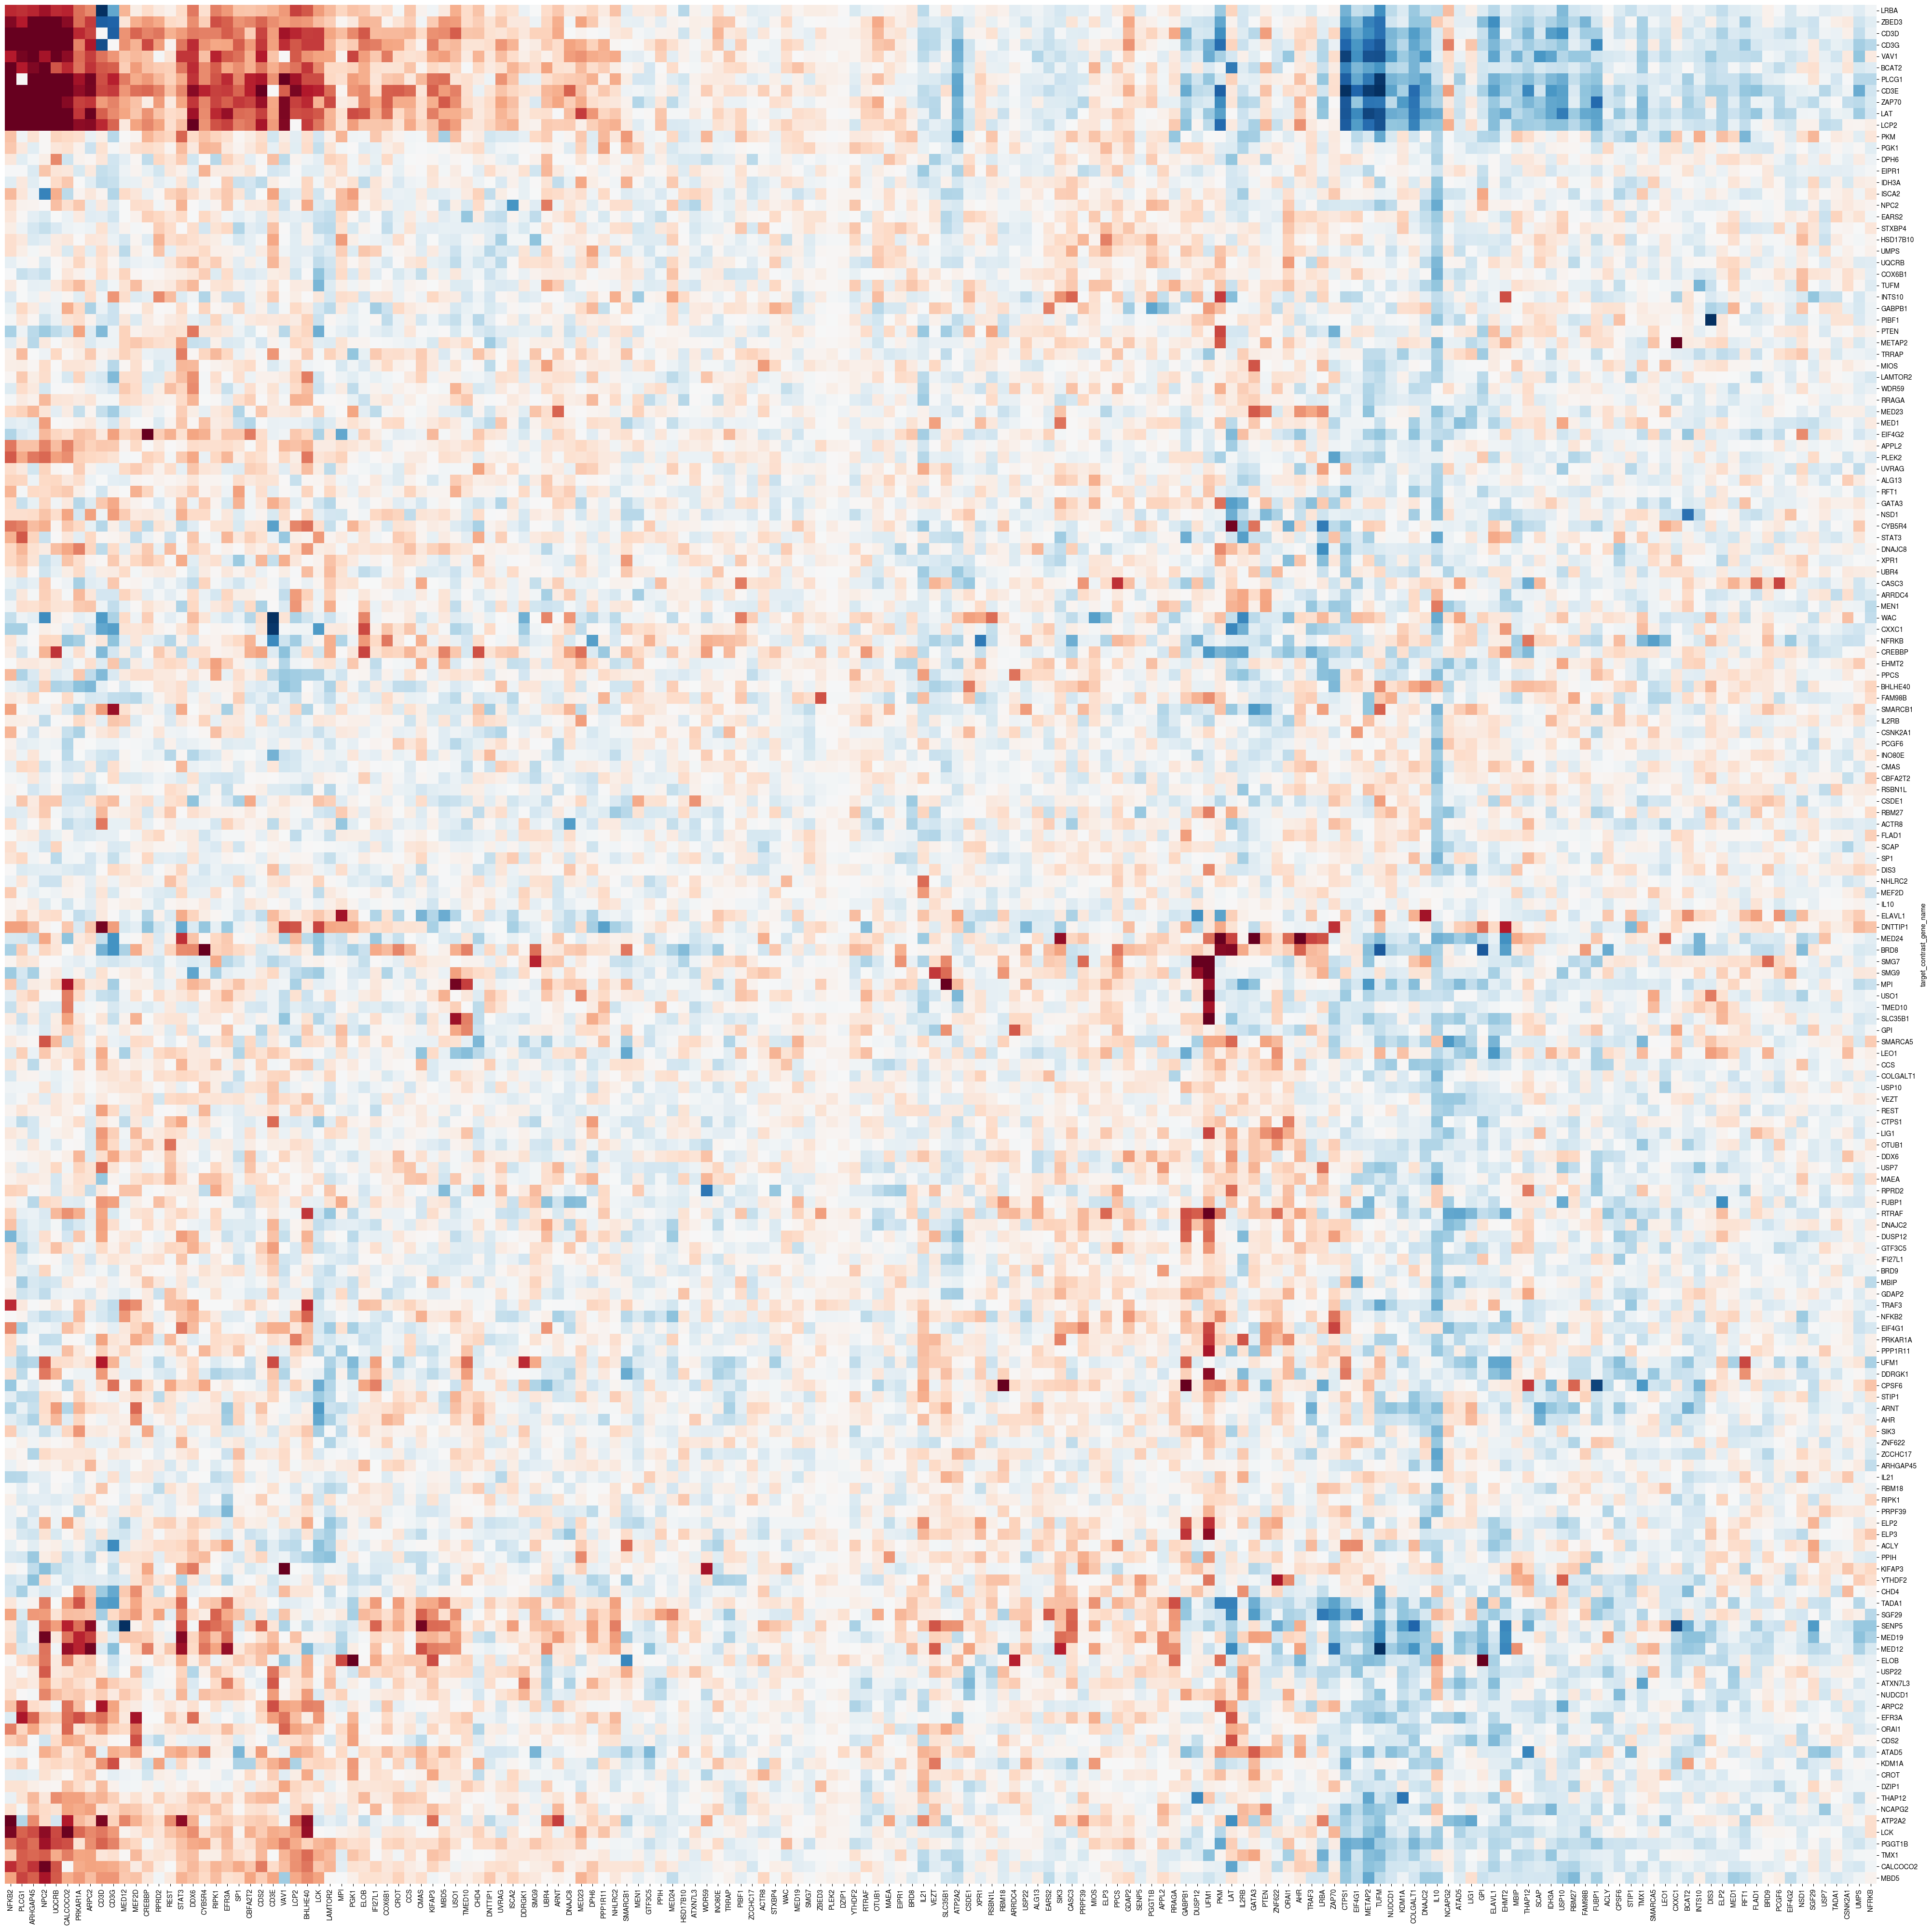

In [139]:


# Visualization 1: Clustermap
g = sns.clustermap(
    reg_matrix,
    method='ward',
    cmap='RdBu_r',
    center=0,
    figsize=(50, 50),
    vmin=-10,
    vmax=10,
    xticklabels=True, 
    yticklabels=True,
    
)

# Hide the row and column dendrograms
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
plt.tight_layout()
plt.savefig('results/IL10_IL21_mininetwork.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [119]:
len(valid_regulators)

282

Analyzing hierarchy for 282 regulators...


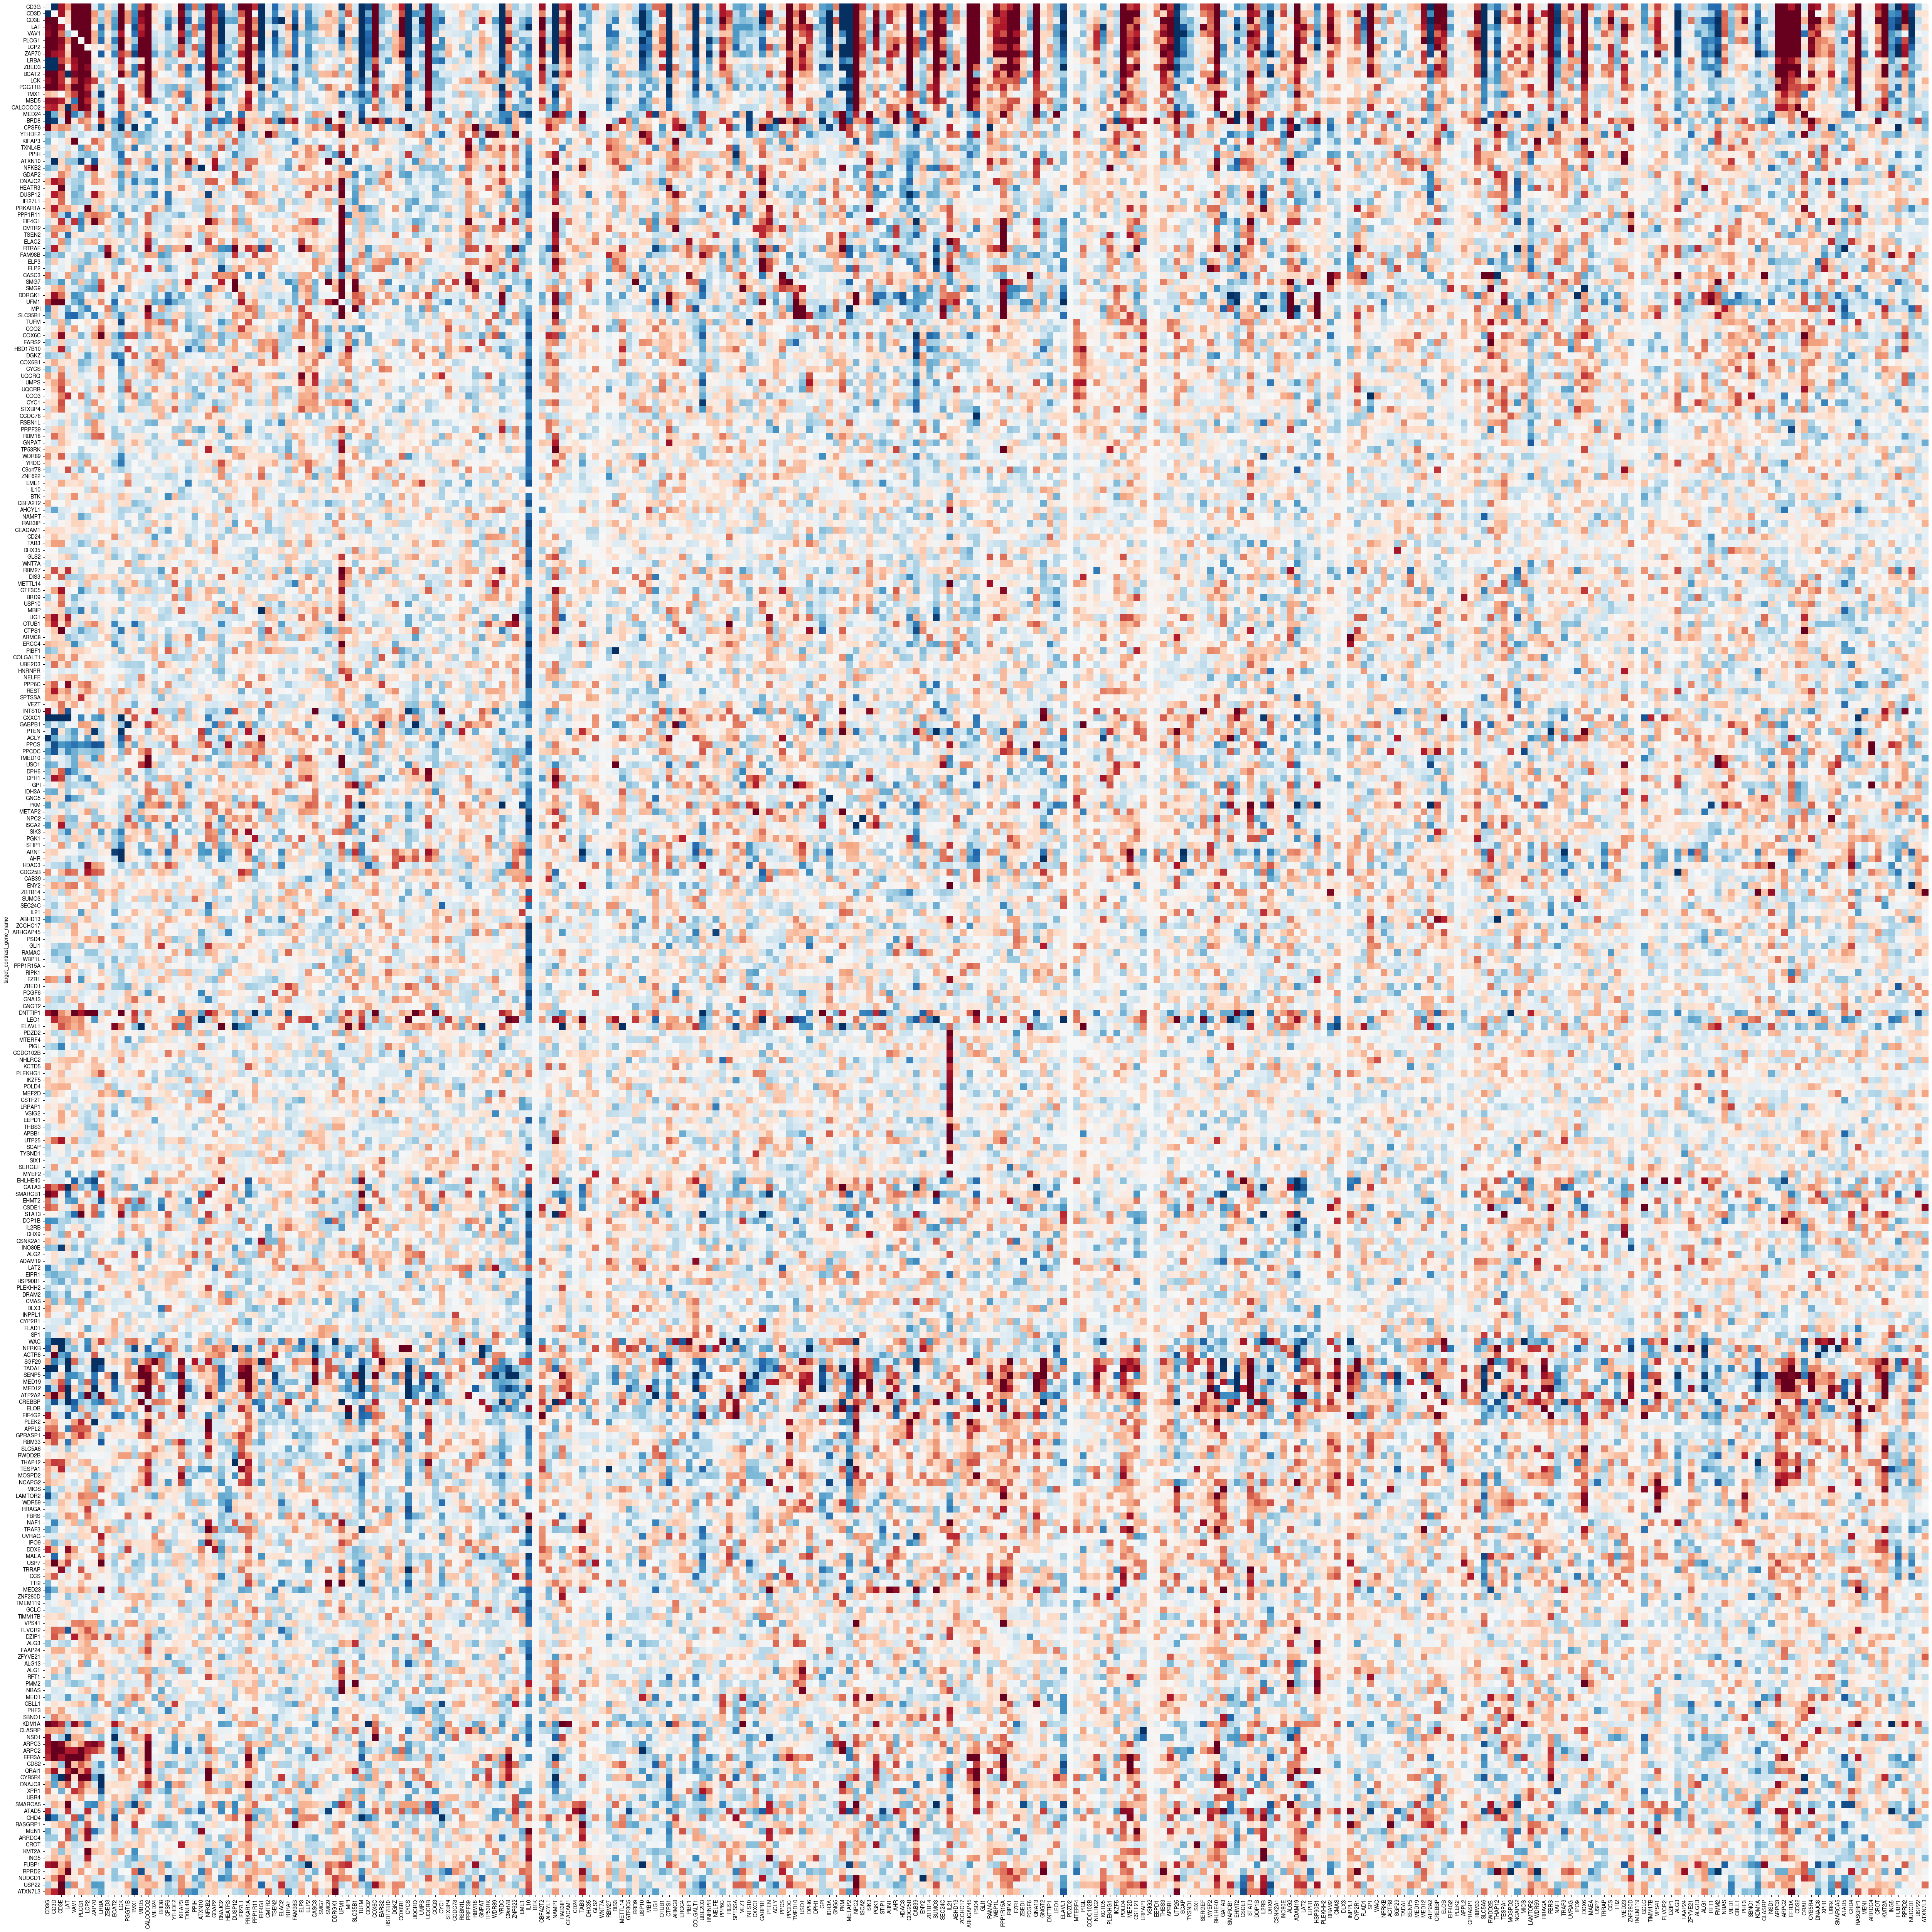

In [125]:
valid_regulators = [g for g in all_regulator_names if g in name_to_id]

print(f"Analyzing hierarchy for {len(valid_regulators)} regulators...")

# Fetch by ID, Store by Name (Fixes mismatch & warning)
# We pull data using the Ensembl ID, but save it with the Gene Name key
reg_data_dict = {
    g_name: adata_stim[:, name_to_id[g_name]].layers['masked_zscore'].flatten()
    for g_name in valid_regulators
}

# Create DataFrame in one go
reg_df_full = pd.DataFrame(reg_data_dict, index=adata_stim.obs['target_contrast_gene_name'])

# Subset rows to only include the perturbations that are regulators
reg_matrix = reg_df_full.loc[valid_regulators].copy()

# Visualization 1: Clustermap
g = sns.clustermap(
    reg_matrix,
    method='ward',
    cmap='RdBu_r',
    center=0,
    figsize=(6, 6),
    vmin=-5,
    vmax=5,
    xticklabels=False, 
    yticklabels=False,
    
)
yticklabel_indices = g.dendrogram_row.reordered_ind
plt.close(g.fig)
regulator_reordered = np.array(valid_regulators)[yticklabel_indices]

plt.figure(figsize=(50, 50), constrained_layout=True)
sns.heatmap(
    reg_matrix.loc[regulator_reordered,regulator_reordered],
    vmin=-5,
    vmax=5,
    xticklabels=True, 
    yticklabels=True,
    cbar=False,
    cmap='RdBu_r',
)

#plt.tight_layout()
#plt.savefig('results/IL10_IL21_mininetwork.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

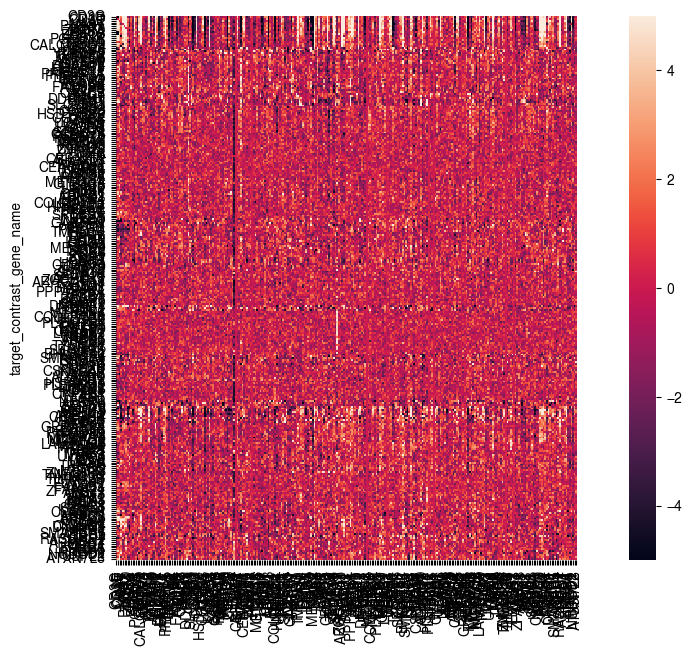

In [122]:
yticklabel_indices = g.dendrogram_row.reordered_ind
#plt.close(g.fig)
regulator_reordered = np.array(valid_regulators)[yticklabel_indices]

plt.figure(figsize=(6, 6), constrained_layout=True)
sns.heatmap(
    reg_matrix.loc[regulator_reordered,regulator_reordered],
    vmin=-5,
    vmax=5,
    xticklabels=True, 
    yticklabels=True,
    cmap='RdBu_r',
)

plt.tight_layout()
#plt.savefig('results/IL10_IL21_mininetwork.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [46]:
reg_matrix

,CD24,SLC5A6,DGKZ,CLASRP,DUSP12,COLGALT1,IDH3A,WBP1L,SCAP,ALG1,...,POLD4,YTHDF2,DNAJC8,RRAGA,ORAI1,THAP12,UFM1,VSIG2,DDX6,AHCYL1
target_contrast_gene_name,,,,,,,,,,,,,,,,,,,,,
CD24,0.000000,-0.793177,-1.669396,1.869987,-0.926894,0.704194,0.580983,0.050721,-0.746268,-1.283213,...,1.182579,0.367664,0.237722,-1.006411,1.194657,2.150342,2.422036,0.003834,0.840577,-0.070184
SLC5A6,0.319922,0.000000,-2.327713,-2.035284,-1.891199,-0.375425,-1.076807,2.013849,-1.040254,-1.977832,...,-0.839915,0.711120,0.176041,-0.585253,-1.223452,-2.653449,-0.640140,-0.085842,5.494860,-0.354386
DGKZ,0.403645,0.662306,0.000000,-0.926139,-0.519333,-0.216428,1.500499,0.484629,-0.347501,0.604256,...,2.074276,2.314246,2.498503,-1.435979,0.955582,2.390289,1.620062,-0.063631,0.561115,3.140365
CLASRP,0.362021,-3.421487,0.103351,0.000000,0.033111,-1.046796,2.500417,0.265233,-2.114233,2.265777,...,0.422953,2.009092,4.033048,1.343949,-1.347306,3.474898,-1.426161,0.044060,3.617824,-1.549668
DUSP12,0.386497,-1.090518,-1.299586,-0.218102,0.000000,0.476531,-0.272697,-0.123063,-0.145055,-1.861771,...,0.719708,0.363497,-0.861807,0.071818,3.158247,2.443354,5.678240,0.098420,3.412619,1.147228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THAP12,0.854587,-1.002135,1.469155,0.828248,-6.511069,-0.059507,-1.682743,-0.458608,-1.158011,-1.991653,...,2.716853,0.615461,0.105831,-0.007251,-1.803164,0.000000,2.689986,1.439606,2.685271,-1.662977
UFM1,-0.796422,1.876746,-2.530808,-0.133176,-1.435268,-1.501486,-0.915666,-0.886443,1.452028,3.400795,...,0.345002,-2.552125,-1.997631,-1.107078,3.149885,-0.660105,0.000000,-0.119357,1.905474,-0.739248
VSIG2,-0.075973,-1.961293,0.641955,1.461941,-0.908800,0.697028,0.677361,0.253944,0.940624,-0.732084,...,1.151409,0.530829,1.011642,0.954816,-0.928078,0.409059,0.240930,0.000000,-0.720703,-0.873899


In [48]:
adata_subset = adata_stim[adata_stim.obs.target_contrast_gene_name.isin(all_regulator_names), adata_stim.var.gene_name.isin(all_regulator_names)].copy()

In [110]:
adata_reg = adata_subset.copy()
adata_reg.X = adata_reg.layers['masked_zscore'].copy()
sc.pp.scale(adata_reg)
sc.pp.pca(adata_reg, n_comps=20)
sc.pp.neighbors(adata_reg, n_neighbors=15)
sc.tl.leiden(adata_reg, resolution=3, key_added='leiden_clusters')
adata_reg.obs.leiden_clusters = adata_reg.obs.leiden_clusters.astype('int')
adata_reg.obs.leiden_clusters = adata_reg.obs.leiden_clusters.astype('category')

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


In [84]:
adata_ds = adata_subset.T.copy()
adata_ds.X = adata_ds.layers['masked_zscore'].copy()
sc.pp.scale(adata_ds)
sc.pp.pca(adata_ds, n_comps=20)
sc.pp.neighbors(adata_ds, n_neighbors=15)
sc.tl.leiden(adata_ds, resolution=3, key_added='leiden_clusters')
adata_ds.obs.leiden_clusters = adata_ds.obs.leiden_clusters.astype('int')
adata_ds.obs.leiden_clusters = adata_ds.obs.leiden_clusters.astype('category')

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


In [111]:
adata_all = adata_reg.copy()
adata_all.obs_names = adata_all.obs.target_contrast_corrected.copy()
adata_all.var = pd.merge(adata_all.var, adata_all.obs['leiden_clusters'], left_index=True, right_index=True)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/anndata/_core/anndata.py:842: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['ENSG00000272398', 'ENSG00000138074', 'ENSG00000149091', 'ENSG00000171262', 'ENSG00000104859']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_7426/4239852042.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('leiden_clusters')
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_7426/4239852042.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.index.tolist())
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:2074: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.o

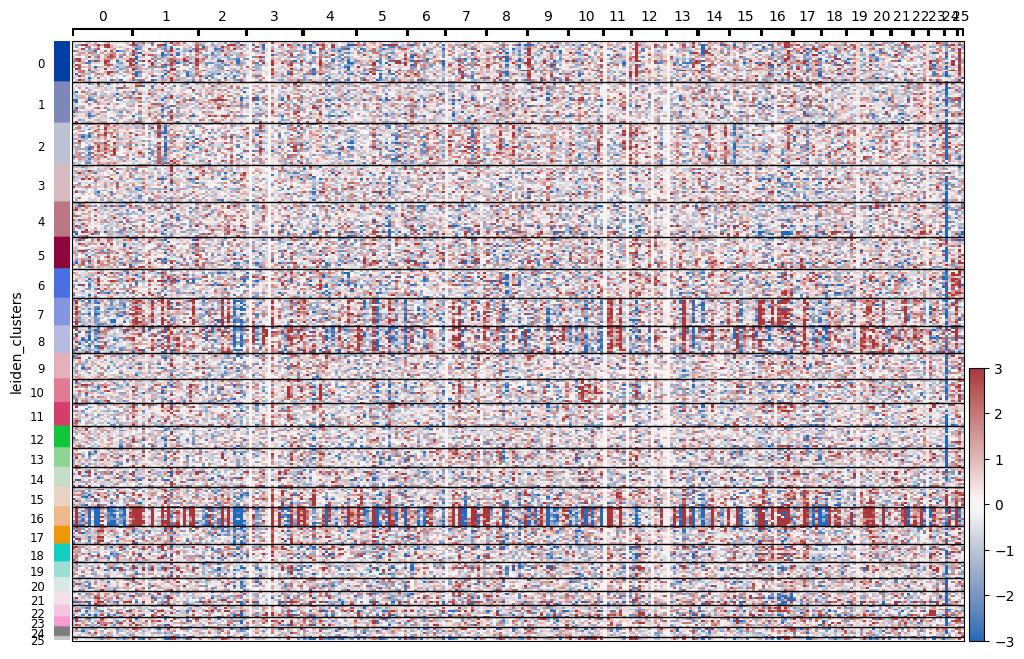

In [112]:
var_group_dict = (
    adata_all.var
    .groupby('leiden_clusters')
    .apply(lambda x: x.index.tolist())
    .to_dict()
)

sc.pl.heatmap(
    adata_all,
    var_names=var_group_dict,     # Passing the dict creates the top column legends
    groupby='leiden_clusters',    # Creates the left row legends
    layer='masked_zscore',
    vmin=-3,
    vmax=3,
    cmap='vlag',
    figsize=(12, 8),              # Increased width slightly to accommodate labels
    var_group_rotation=0          # Keeps column group labels horizontal (optional)
)

In [97]:
adata_all[:,adata_all.var.leiden_clusters==4].var

,gene_ids,gene_name,leiden_clusters
ENSG00000005339,ENSG00000005339,CREBBP,4
ENSG00000006715,ENSG00000006715,VPS41,4
ENSG00000065615,ENSG00000065615,CYB5R4,4
ENSG00000075945,ENSG00000075945,KIFAP3,4
ENSG00000078699,ENSG00000078699,CBFA2T2,4
ENSG00000118058,ENSG00000118058,KMT2A,4
ENSG00000120063,ENSG00000120063,GNA13,4
ENSG00000129158,ENSG00000129158,SERGEF,4
ENSG00000132294,ENSG00000132294,EFR3A,4
ENSG00000134146,ENSG00000134146,DPH6,4


In [113]:
adata_all[adata_all.obs.leiden_clusters==16].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,leiden_clusters
target_contrast_corrected,,,,,,,,
ENSG00000124181,PLCG1,Stim8hr,ENSG00000124181,87,421.0,ENSG00000124181,PLCG1,16
ENSG00000043462,LCP2,Stim8hr,ENSG00000043462,240,153.0,ENSG00000043462,LCP2,16
ENSG00000115085,ZAP70,Stim8hr,ENSG00000115085,249,144.0,ENSG00000115085,ZAP70,16
ENSG00000160654,CD3G,Stim8hr,ENSG00000160654,274,230.0,ENSG00000160654,CD3G,16
ENSG00000141968,VAV1,Stim8hr,ENSG00000141968,326,504.0,ENSG00000141968,VAV1,16
ENSG00000132846,ZBED3,Stim8hr,ENSG00000132846,344,417.0,ENSG00000132846,ZBED3,16
ENSG00000105552,BCAT2,Stim8hr,ENSG00000105552,366,198.0,ENSG00000105552,BCAT2,16
ENSG00000167286,CD3D,Stim8hr,ENSG00000167286,436,185.0,ENSG00000167286,CD3D,16
ENSG00000198851,CD3E,Stim8hr,ENSG00000198851,490,234.0,ENSG00000198851,CD3E,16


In [81]:
genelist = ['MED24', 'MEN1', 'ATP2A2', 'CYB5R4', 'GATA3', 'STAT3', 'SGF29', 'NFKB2', 'KDM1A', 'MED12', 'TADA1', 'CD3D', 'USP22']

In [82]:
adata_reg[adata_reg.obs.target_contrast_gene_name.isin(genelist)].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,leiden_clusters
ENSG00000124422_Stim8hr,USP22,Stim8hr,ENSG00000124422,46,1371.0,ENSG00000124422,USP22,15
ENSG00000107485_Stim8hr,GATA3,Stim8hr,ENSG00000107485,77,818.0,ENSG00000107485,GATA3,12
ENSG00000133895_Stim8hr,MEN1,Stim8hr,ENSG00000133895,120,189.0,ENSG00000133895,MEN1,15
ENSG00000008838_Stim8hr,MED24,Stim8hr,ENSG00000008838,257,700.0,ENSG00000008838,MED24,19
ENSG00000077150_Stim8hr,NFKB2,Stim8hr,ENSG00000077150,395,2152.0,ENSG00000077150,NFKB2,0
ENSG00000065615_Stim8hr,CYB5R4,Stim8hr,ENSG00000065615,426,211.0,ENSG00000065615,CYB5R4,18
ENSG00000167286_Stim8hr,CD3D,Stim8hr,ENSG00000167286,436,185.0,ENSG00000167286,CD3D,16
ENSG00000004487_Stim8hr,KDM1A,Stim8hr,ENSG00000004487,447,541.0,ENSG00000004487,KDM1A,18
ENSG00000184634_Stim8hr,MED12,Stim8hr,ENSG00000184634,523,219.0,ENSG00000184634,MED12,8
ENSG00000168610_Stim8hr,STAT3,Stim8hr,ENSG00000168610,536,255.0,ENSG00000168610,STAT3,3


In [45]:
comparison_df

target,IL10,IL21
perturbation,,
SMG7,-3.071939,-3.052474
PPCS,-4.265372,4.167455
PRKAR1A,-3.330647,3.061518
MPI,-2.567954,-2.387708
EIF4G2,-2.515628,-3.377709
LRBA,-2.539027,-2.731439
LCP2,-3.974626,-2.211031
ZAP70,-3.176133,-2.476994
MED24,-4.799221,-3.620012


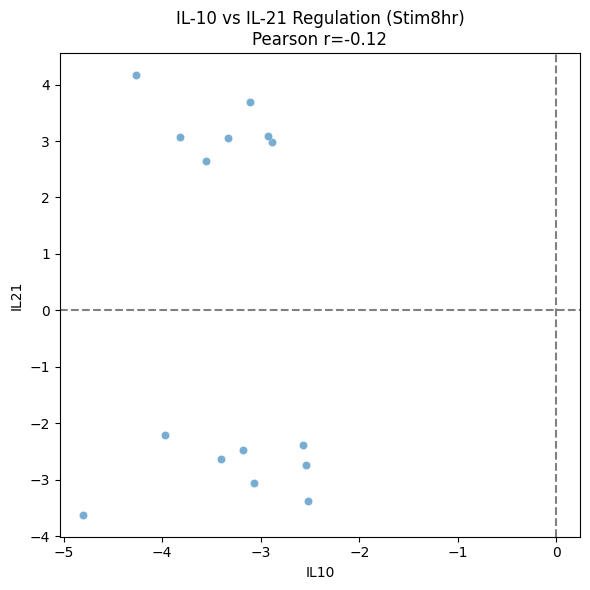

In [25]:
comparison_df = sig_regulators.pivot(
    index='perturbation', 
    columns='target', 
    values='masked_zscore'
).dropna()

corr_val = comparison_df['IL10'].corr(comparison_df['IL21'])

plt.figure(figsize=(6, 6))
sns.scatterplot(data=comparison_df, x='IL10', y='IL21', alpha=0.6)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.title(f'IL-10 vs IL-21 Regulation (Stim8hr)\nPearson r={corr_val:.2f}')
plt.tight_layout()
plt.show()

In [11]:
adata_de.var

,gene_ids,gene_name
ENSG00000000003,ENSG00000000003,TSPAN6
ENSG00000000419,ENSG00000000419,DPM1
ENSG00000000457,ENSG00000000457,SCYL3
ENSG00000000460,ENSG00000000460,C1orf112
ENSG00000000938,ENSG00000000938,FGR
...,...,...
ENSG00000290292,ENSG00000290292,HOMEZ
ENSG00000290795,ENSG00000290795,C2orf83
ENSG00000290797,ENSG00000290797,ENSG00000290797
ENSG00000291096,ENSG00000291096,ENSG00000291096


In [12]:
adata_de.obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected
ENSG00000012963_Stim8hr,UBR7,Stim8hr,ENSG00000012963,0,491.0,ENSG00000012963,UBR7
ENSG00000017260_Stim8hr,ATP2C1,Stim8hr,ENSG00000017260,0,469.0,ENSG00000017260,ATP2C1
ENSG00000067606_Stim8hr,PRKCZ,Stim8hr,ENSG00000067606,0,427.0,ENSG00000067606,PRKCZ
ENSG00000092929_Stim8hr,UNC13D,Stim8hr,ENSG00000092929,0,830.0,ENSG00000092929,UNC13D
ENSG00000100504_Stim8hr,PYGL,Stim8hr,ENSG00000100504,0,414.0,ENSG00000100504,PYGL
...,...,...,...,...,...,...,...
ENSG00000198342_Rest,ZNF442,Rest,ENSG00000198342,680,324.0,ENSG00000198342,ZNF442
ENSG00000205572_Rest,SERF1B,Rest,ENSG00000205572,680,44.0,ENSG00000205572,SERF1B
ENSG00000221890_Rest,NPTXR,Rest,ENSG00000221890,680,293.0,ENSG00000221890,NPTXR
ENSG00000236320_Rest,SLFN14,Rest,ENSG00000236320,680,848.0,ENSG00000236320,SLFN14


In [ ]:
# ... (Continuing from Step 1 code) ...

# 1. Define the universe of regulators to cross-reference
# Filter to ensure these genes exist as columns (measured vars) in adata
valid_regulators = [g for g in all_regulator_genes if g in adata_de.var['gene_name'].values]

# 2. Extract the square matrix (Regulators x Regulators)
# Find indices for these regulator genes in the var (columns)
reg_var_indices = [adata_de.var[adata_de.var['gene_name'] == g].index[0] for g in valid_regulators]

# Extract data for these specific columns
reg_data = []
for obs_name in valid_regulators:
    # Get the row index for the perturbation
    if obs_name in adata_de.obs['target_contrast_gene_name'].values:
        obs_idx = adata_de.obs[adata_de.obs['target_contrast_gene_name'] == obs_name].index[0]
        
        # We need to extract the row, then slice by the regulator column indices
        # Note: Accessing backed anndata by row can be slower; optimization depends on file structure
        # A faster approach for sparse access is often to load the specific columns first (as done below)
        pass 

# Optimized extraction: Load columns for valid_regulators, then filter rows
# This avoids row-slicing a backed object which can be inefficient
reg_df = pd.DataFrame(index=adata_de.obs['target_contrast_gene_name'])

print("Extracting regulator matrix...")
for g, idx in zip(valid_regulators, reg_var_indices):
    reg_df[g] = adata_de[:, idx].layers['masked_zscore'].flatten()

# Filter rows to only include the perturbations that are also regulators
reg_matrix = reg_df.loc[valid_regulators].copy()

# 3. Visualization: Clustermap to reveal hierarchy
# Rows = Perturbations, Cols = Effects on other regulators
g = sns.clustermap(
    reg_matrix,
    cmap='RdBu_r',
    center=0,
    figsize=(10, 10),
    xticklabels=True,
    yticklabels=True
)
plt.title("Hierarchical Regulation: Regulators vs. Regulators")
plt.show()

In [7]:
reg_df

,DUSP12,COLGALT1,IDH3A,QSER1,PMVK,WBP1L,SCAP,CCDC6,ALG1,NPC2,...,POLD4,ITK,DNAJC8,RRAGA,ORAI1,UFM1,BTAF1,UVRAG,AHCYL1,LIG3
target_contrast_gene_name,,,,,,,,,,,,,,,,,,,,,
UBR7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATP2C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRKCZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNC13D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PYGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SERF1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NPTXR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
